In [1]:
# MNIST Project with Real-time Training Visualization
# By Jisang Yun

In [2]:
# Cell 1: Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

# Enable inline plotting
%matplotlib inline

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Cell 2: Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Cell 3: Data preprocessing
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(f'Train Size: {len(train_dataset)}, Test Size: {len(test_dataset)}')

Train Size: 60000, Test Size: 10000


In [5]:
# Cell 4: Data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Input Size: torch.Size([64, 1, 28, 28])


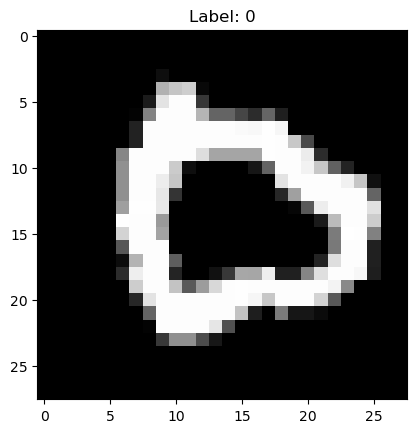

In [6]:
# Cell 5: Show sample image
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print("Input Size:", example_data.size())
    
    example_image_numpy = example_image.permute(1, 2, 0).numpy()
    plt.imshow(example_image_numpy.squeeze(), cmap='gray')
    plt.title(f"Label: {example_labels[0]}")
    plt.show()
    break

In [7]:
# Cell 7: Define SimpleCNN model
class SimpleCNN(nn.Module):
   def __init__(self):
       super(SimpleCNN, self).__init__()
       # Convolutional layers
       self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
       self.bn1 = nn.BatchNorm2d(32) # Batch normalization after conv1
       self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
       self.bn2 = nn.BatchNorm2d(64)
       self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
       self.bn3 = nn.BatchNorm2d(128)
       # Activation and pooling layers
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # Only define once
       self.relu = nn.ReLU()
       # Automatically calculate the input size for fully connected layer
       self.fc_input_size = self._get_conv_output_size()
       # Fully connected layers
       self.fc1 = nn.Linear(self.fc_input_size, 128)
       self.dropout = nn.Dropout(0.5)
       self.fc2 = nn.Linear(128, 20)
       self.fc3 = nn.Linear(20, 10)

   def _get_conv_output_size(self):
       """Automatically calculate the output size of convolutional layers"""
       with torch.no_grad():
           # Test with MNIST image size (1, 28, 28)
           x = torch.zeros(1, 1, 28, 28)
           # Forward pass through conv layers without final pooling
           x = self.pool(self.relu(self.conv1(x))) # 28x28 -> 14x14
           x = self.pool(self.relu(self.conv2(x))) # 14x14 -> 7x7
           x = self.relu(self.conv3(x))            # 7x7 -> 7x7 (no pooling)
           return x.view(1, -1).size(1)

   def forward(self, x):
       # Convolutional layers with BatchNorm, ReLU and pooling
       x = self.pool(self.relu(self.bn1(self.conv1(x)))) # (batch, 32, 14, 14)
       x = self.pool(self.relu(self.bn2(self.conv2(x)))) # (batch, 64, 7, 7)
       x = self.relu(self.bn3(self.conv3(x)))            # (batch, 128, 7, 7) - no pooling
       # Flatten the tensor for fully connected layers
       x = x.view(x.size(0), -1)
       # Fully connected layers
       x = self.relu(self.fc1(x))
       x = self.dropout(x)
       x = self.relu(self.fc2(x))
       x = self.fc3(x) # Final output layer (no activation)
       return x

In [8]:
# Cell 8: Initialize model, loss, optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001) 

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 898,854 parameters


In [9]:
# Cell 9: Real-time visualization function
def plot_training_progress(train_losses, epoch_losses, current_epoch, total_epochs):
    clear_output(wait=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    if train_losses:
        ax1.plot(train_losses, alpha=0.7, linewidth=0.8, color='blue')
        ax1.set_title(f'Training Loss per Batch (Epoch {current_epoch}/{total_epochs})')
        ax1.set_xlabel('Batch Number')
        ax1.set_ylabel('Loss')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(1.0, max(train_losses) if train_losses else 1.0))
    
    if epoch_losses:
        epochs_range = range(1, len(epoch_losses) + 1)
        ax2.plot(epochs_range, epoch_losses, 'r-', linewidth=2, marker='o', markersize=4)
        ax2.set_title('Average Training Loss per Epoch')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Average Loss')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(0, total_epochs)
        if epoch_losses:
            ax2.set_ylim(0, max(epoch_losses) * 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    if train_losses:
        print(f"Current Batch Loss: {train_losses[-1]:.4f}")
    if epoch_losses:
        print(f"Last Epoch Average Loss: {epoch_losses[-1]:.4f}")
        print(f"Best Epoch Loss: {min(epoch_losses):.4f}")


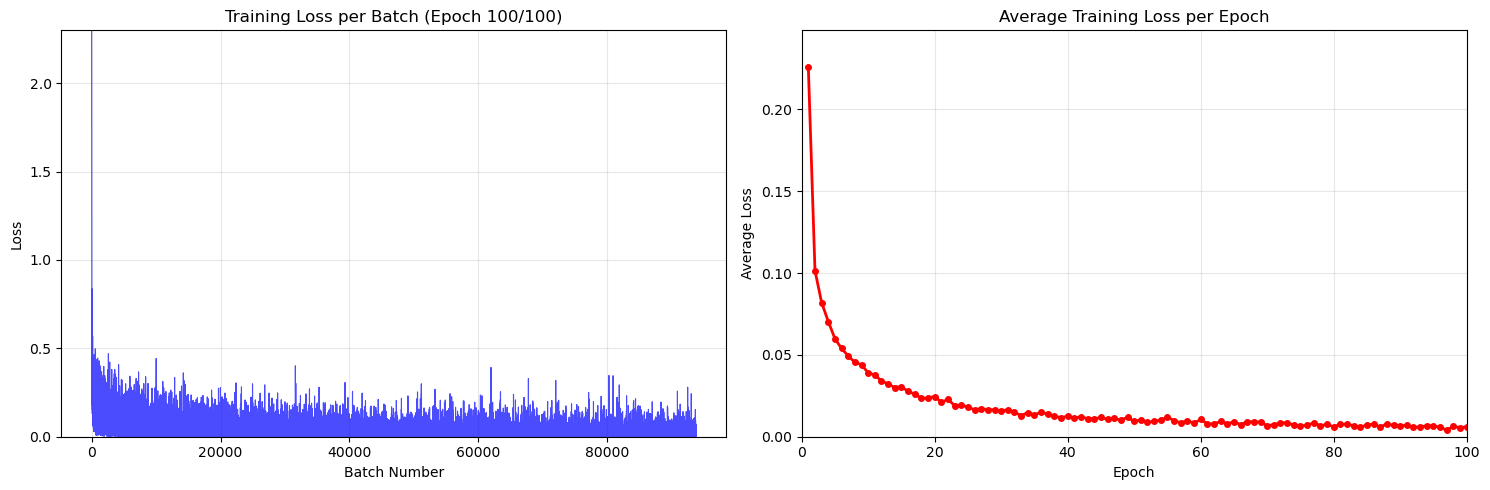

Current Batch Loss: 0.0000
Last Epoch Average Loss: 0.0061
Best Epoch Loss: 0.0041
Epoch 100 completed. Average Loss: 0.0061
Training Finished!


In [10]:
# Cell 10: Training loop
num_epochs = 100 
train_losses = []
epoch_losses = []
running_loss = 0.0
plot_interval = 50

print("Starting Training...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_losses.append(current_loss)
        epoch_loss += current_loss
        batch_count += 1
        running_loss += current_loss
        
        if i % 100 == 99:
            avg_loss = running_loss / 100
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}")
            running_loss = 0.0
        
        # Update plot every 50 batches
        if i % plot_interval == 0:
            plot_training_progress(train_losses, epoch_losses, epoch + 1, num_epochs)
    
    # End of epoch
    avg_epoch_loss = epoch_loss / batch_count if batch_count > 0 else 0
    epoch_losses.append(avg_epoch_loss)
    plot_training_progress(train_losses, epoch_losses, epoch + 1, num_epochs)
    
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")

print('Training Finished!')


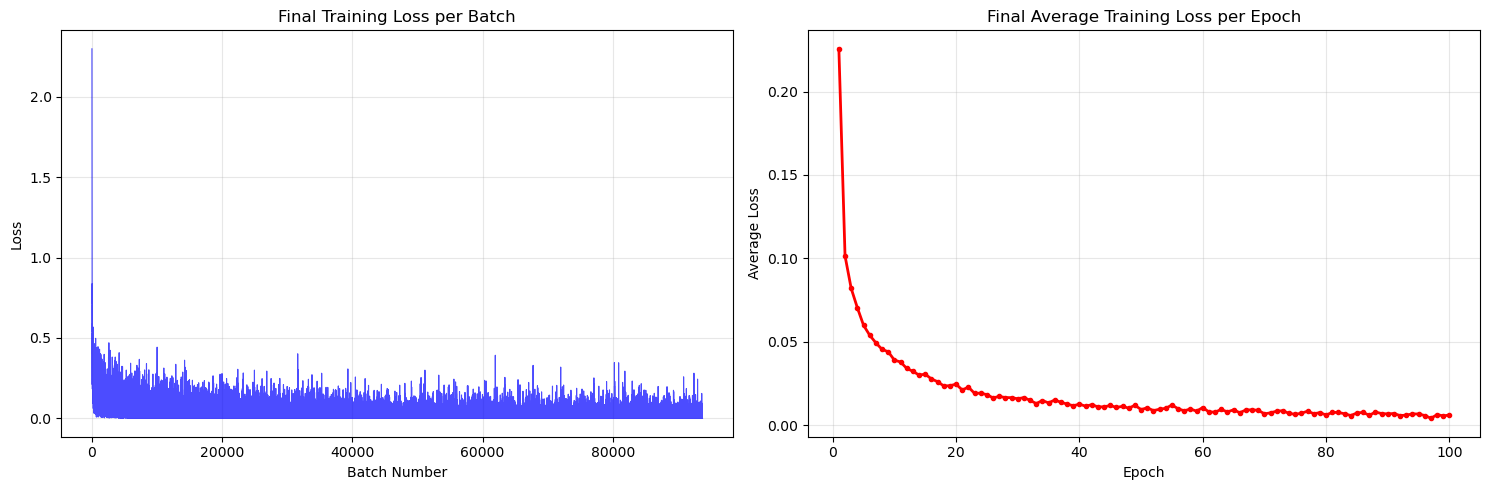

Initial Loss: 2.2996
Final Loss: 0.0000
Best Epoch Loss: 0.0041
Loss Reduction: 2.2996


In [11]:
# Cell 11: Final training visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, alpha=0.7, linewidth=0.8, color='blue')
plt.title('Final Training Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), epoch_losses, 'r-', linewidth=2, marker='o', markersize=3)
plt.title('Final Average Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial Loss: {train_losses[0]:.4f}")
print(f"Final Loss: {train_losses[-1]:.4f}")
print(f"Best Epoch Loss: {min(epoch_losses):.4f}")
print(f"Loss Reduction: {train_losses[0] - train_losses[-1]:.4f}")

In [12]:
# Cell 12: Model evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_targets)

print("Evaluating model...")
predictions, true_labels = evaluate_model(model, test_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision_macro = precision_score(true_labels, predictions, average='macro')
recall_macro = recall_score(true_labels, predictions, average='macro')
f1_macro = f1_score(true_labels, predictions, average='macro')

print("Overall Performance Metrics:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

Evaluating model...
Overall Performance Metrics:
Accuracy: 0.9932 (99.32%)
Precision (Macro): 0.9931
Recall (Macro): 0.9931
F1-Score (Macro): 0.9931


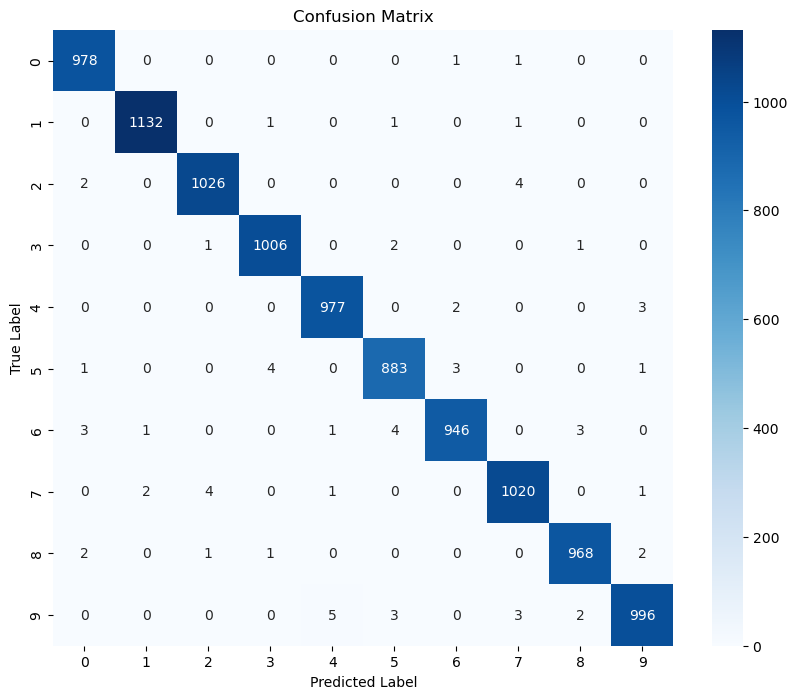

In [13]:
# Cell 13: Confusion Matrix
mnist_classes = [str(i) for i in range(10)]
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=mnist_classes,
            yticklabels=mnist_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


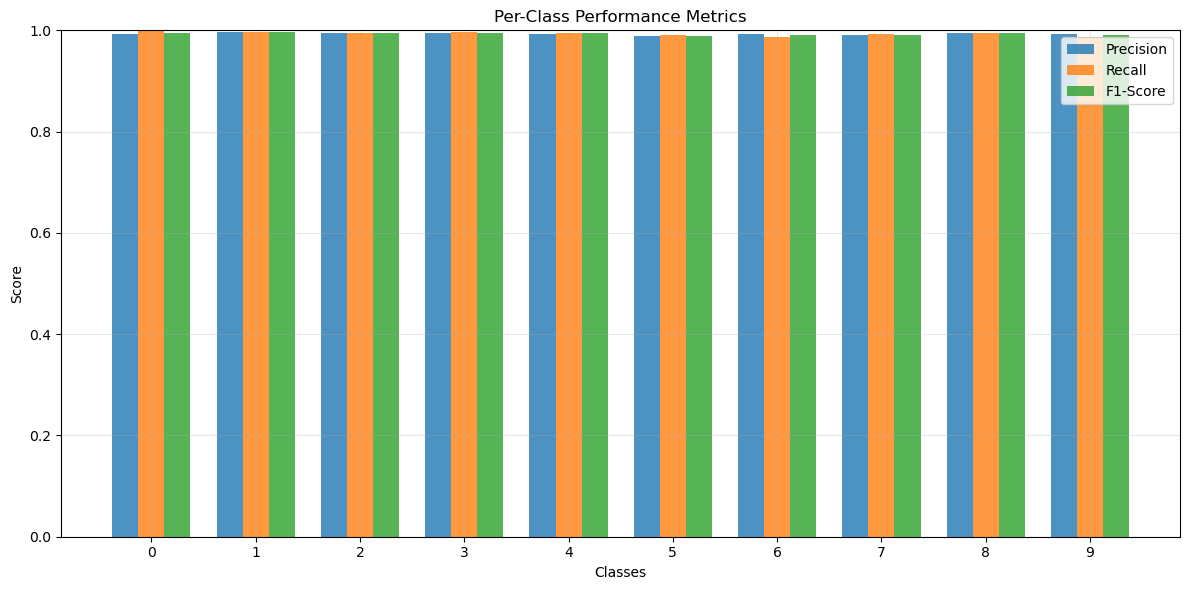

In [14]:
# Cell 14: Per-class performance
precision_per_class = precision_score(true_labels, predictions, average=None)
recall_per_class = recall_score(true_labels, predictions, average=None)
f1_per_class = f1_score(true_labels, predictions, average=None)

x = np.arange(len(mnist_classes))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
plt.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
plt.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Per-Class Performance Metrics')
plt.xticks(x, mnist_classes)
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [15]:
# Cell 15: Classification report
print("Detailed Classification Report:")
report = classification_report(true_labels, predictions, target_names=mnist_classes)
print(report)

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [16]:
# Cell 16: Save submission
print("Generating submission...")
submission_predictions = []

model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        submission_predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    "ImageId": range(1, len(submission_predictions) + 1),
    "Label": submission_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"Submission saved! Predictions: {len(submission_predictions)}")
print(f"Final Test Accuracy: {accuracy*100:.2f}%")

Generating submission...
Submission saved! Predictions: 10000
Final Test Accuracy: 99.32%
